In [17]:
# Run this cell first (only if packages are missing).
# In Jupyter you can run shell installs with a leading !; if using virtualenv, install from terminal instead.

!pip install --quiet pandas matplotlib seaborn python-pptx reportlab

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
%matplotlib inline

print("Libraries ready.")


Libraries ready.


In [18]:
# Update this path if your file is stored elsewhere
DATAFILE = "student_feedback.csv"

# Check the file exists
if not Path(DATAFILE).exists():
    raise FileNotFoundError(f"{DATAFILE} not found. Place it in the notebook folder or update the path.")

# Load
df = pd.read_csv(DATAFILE)

# Quick preview
print("Shape:", df.shape)
display(df.head())
display(df.info())


Shape: (1001, 10)


,Unnamed: 0,Student ID,Well versed with the subject,Explains concepts in an understandable way,Use of presentations,Degree of difficulty of assignments,Solves doubts willingly,Structuring of the course,Provides support for students going above and beyond,Course recommendation based on relevance
0,0,340,5,2,7,6,9,2,1,8
1,1,253,6,5,8,6,2,1,2,9
2,2,680,7,7,6,5,4,2,3,1
3,3,806,9,6,7,1,5,9,4,6
4,4,632,8,10,8,4,6,6,9,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 10 columns):
 #   Column                                                Non-Null Count  Dtype
---  ------                                                --------------  -----
 0   Unnamed: 0                                            1001 non-null   int64
 1   Student ID                                            1001 non-null   int64
 2   Well versed with the subject                          1001 non-null   int64
 3   Explains concepts in an understandable way            1001 non-null   int64
 4   Use of presentations                                  1001 non-null   int64
 5   Degree of difficulty of assignments                   1001 non-null   int64
 6   Solves doubts willingly                               1001 non-null   int64
 7   Structuring of the course                             1001 non-null   int64
 8   Provides support for students going above and beyond  1001 non-null   int64
 9

None

In [19]:
# Work on a copy
df_clean = df.copy()

# 1) Drop common unwanted columns (Unnamed, ID columns)
drop_candidates = [c for c in df_clean.columns if c.lower().startswith('unnamed') or 'student id' in c.lower() or c.lower()=='id']
if drop_candidates:
    print("Dropping:", drop_candidates)
    df_clean = df_clean.drop(columns=drop_candidates, errors='ignore')
else:
    print("No obvious ID/Unnamed columns to drop.")

# 2) Convert columns to numeric where appropriate (coerce errors -> NaN for numeric detection)
for c in df_clean.columns:
    # if column contains many numeric-like entries, convert
    # We'll attempt conversion for all columns and keep if possible
    try:
        converted = pd.to_numeric(df_clean[c], errors='coerce')
        # if majority convertible -> replace column
        convert_ratio = (~converted.isna()).mean()
        if convert_ratio > 0.5:  # more than 50% convertible => treat as numeric
            df_clean[c] = converted
            print(f"Converted to numeric: {c} (convert_ratio={convert_ratio:.2f})")
    except Exception as e:
        pass

# 3) Strip whitespace for object columns
for c in df_clean.select_dtypes(include=['object']).columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# 4) Replace obvious invalid numeric values (negative) with NaN
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df_clean.loc[df_clean[c] < 0, c] = np.nan

print("\nFinal columns used for analysis (numeric survey columns):")
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)


Dropping: ['Unnamed: 0', 'Student ID']
Converted to numeric: Well versed with the subject (convert_ratio=1.00)
Converted to numeric: Explains concepts in an understandable way (convert_ratio=1.00)
Converted to numeric: Use of presentations (convert_ratio=1.00)
Converted to numeric: Degree of difficulty of assignments (convert_ratio=1.00)
Converted to numeric: Solves doubts willingly (convert_ratio=1.00)
Converted to numeric: Structuring of the course (convert_ratio=1.00)
Converted to numeric: Provides support for students going above and beyond (convert_ratio=1.00)
Converted to numeric: Course recommendation based on relevance (convert_ratio=1.00)

Final columns used for analysis (numeric survey columns):
['Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on

In [20]:
# Compute per-question descriptive stats for numeric columns
question_cols = num_cols.copy()
stats = df_clean[question_cols].agg(['count','mean','median','min','max','std']).T
stats = stats.reset_index().rename(columns={'index':'question'}).round(3)
display(stats)


,question,count,mean,median,min,max,std
0,Well versed with the subject,1001.0,7.498,8.0,5.0,10.0,1.693
1,Explains concepts in an understandable way,1001.0,6.082,6.0,2.0,10.0,2.597
2,Use of presentations,1001.0,5.942,6.0,4.0,8.0,1.416
3,Degree of difficulty of assignments,1001.0,5.431,5.0,1.0,10.0,2.869
4,Solves doubts willingly,1001.0,5.475,6.0,1.0,10.0,2.875
5,Structuring of the course,1001.0,5.636,6.0,1.0,10.0,2.920
6,Provides support for students going above and ...,1001.0,5.662,6.0,1.0,10.0,2.892
7,Course recommendation based on relevance,1001.0,5.598,6.0,1.0,10.0,2.887


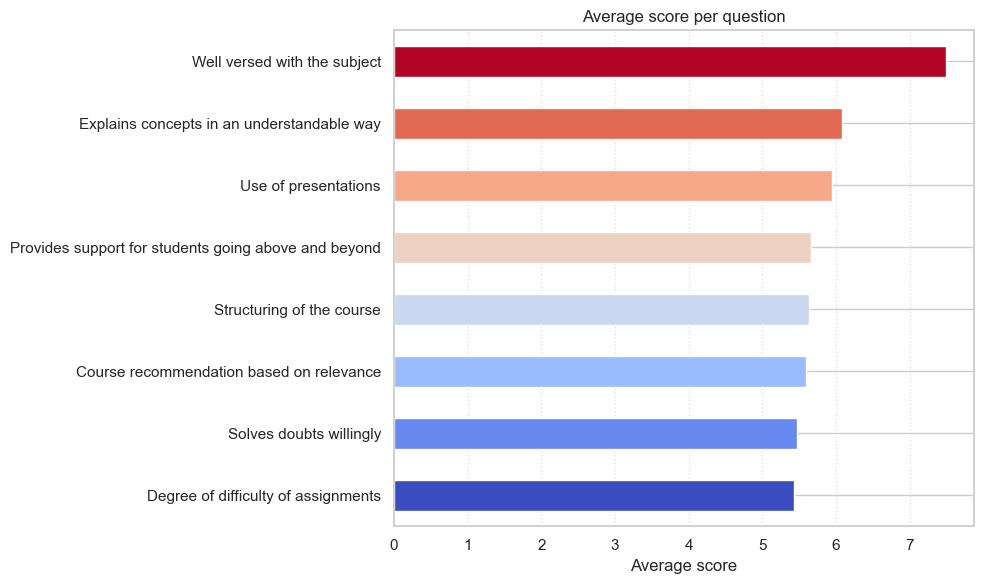

In [22]:
# Average per question (sorted)
means = df_clean[question_cols].mean().sort_values()
plt.figure(figsize=(10,6))

# Using a colormap to assign different colors to each bar
# This creates a color gradient based on the values
cmap = plt.cm.coolwarm  # Using coolwarm colormap
colors = cmap(np.linspace(0, 1, len(means)))

means.plot(kind='barh', color=colors)
plt.xlabel('Average score')
plt.title('Average score per question')
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


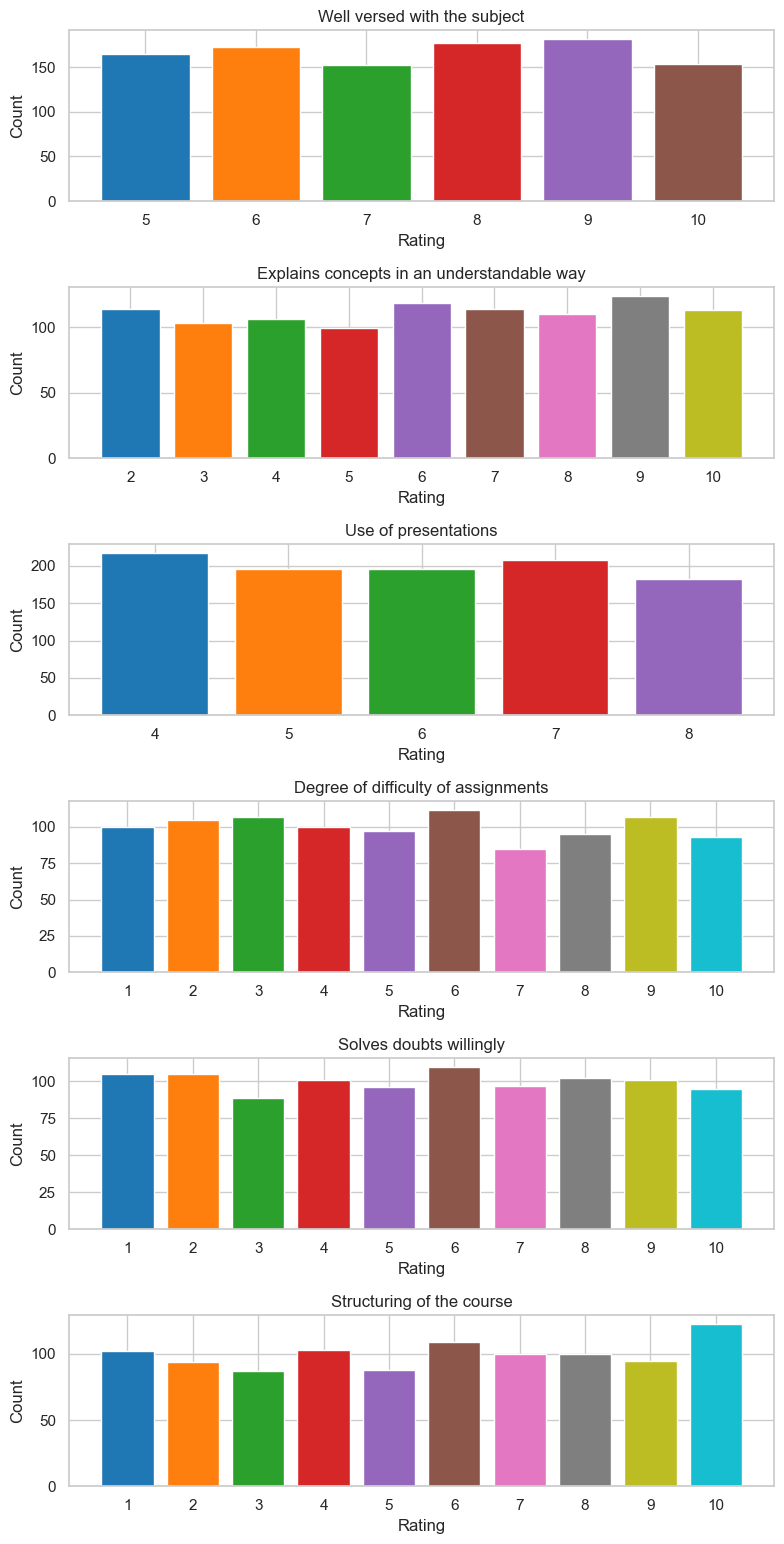

In [26]:
# Plot distributions for first up to 6 questions (adjust as needed)
cols_to_plot = question_cols[:6]
n = len(cols_to_plot)
fig, axes = plt.subplots(nrows=n, figsize=(8, 2.6*n))

# Define a colormap for different colors
colors = plt.cm.tab10.colors  # Using tab10 colormap which has distinct colors

for i, c in enumerate(cols_to_plot):
    ax = axes[i] if n>1 else axes
    data = df_clean[c].dropna().astype(int)
    counts = data.value_counts().sort_index()
    
    # Create bars with different colors for each rating value
    for j, (rating, count) in enumerate(counts.items()):
        # Use modulo to cycle through colors if there are more ratings than colors
        color_idx = j % len(colors)
        ax.bar(str(rating), count, color=colors[color_idx], label=f'Rating {rating}')
    
    ax.set_title(c)
    ax.set_ylabel('Count')
    ax.set_xlabel('Rating')
    
    # Add legend if you want to show which color corresponds to which rating
    # Uncomment the next line if you want legends
    # ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

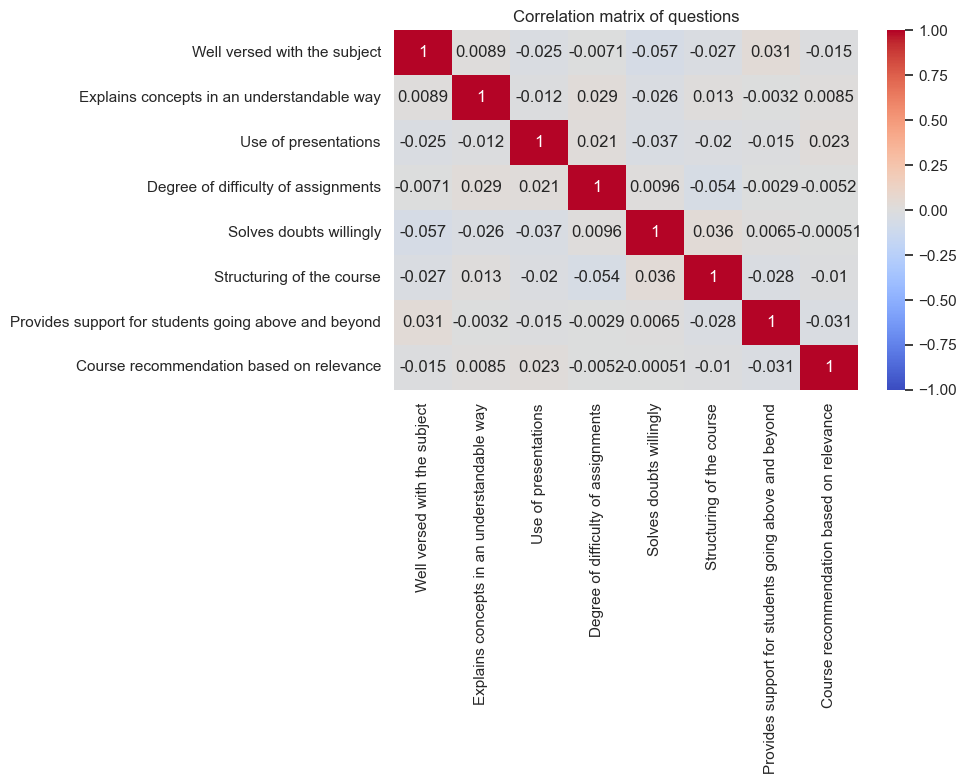

In [24]:
plt.figure(figsize=(10,8))
corr = df_clean[question_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of questions')
plt.tight_layout()
plt.show()


In [25]:
# Use means to find top/bottom
means_sorted = means
top3 = means_sorted.tail(3)
bottom3 = means_sorted.head(3)

print("Top 3 strengths:")
for q, m in top3.items():
    print(f"- {q}: avg {m:.2f}")

print("\nTop 3 areas to improve:")
for q, m in bottom3.items():
    print(f"- {q}: avg {m:.2f}")


Top 3 strengths:
- Use of presentations: avg 5.94
- Explains concepts in an understandable way: avg 6.08
- Well versed with the subject: avg 7.50

Top 3 areas to improve:
- Degree of difficulty of assignments: avg 5.43
- Solves doubts willingly: avg 5.47
- Course recommendation based on relevance: avg 5.60
